### Libraries import

In [1]:
import mujoco
import mediapy as media
import numpy as np
from numpy.linalg import inv

from scipy.linalg import logm
import matplotlib.pyplot as plt

renderer = None

In [2]:
def skew_to_vector(skew_matrix):
    return np.array([skew_matrix[2, 1], skew_matrix[0, 2], skew_matrix[1, 0]])

def so3_error(R, Rd):
    error_matrix = R.T @ Rd
    error_log = logm(error_matrix)
    error_vector = skew_to_vector(error_log)
    return error_vector

In [3]:
from numpy import sin,cos,pi
def Rz(q):
    Rz = np.array([
        [cos(q), -sin(q), 0],
        [sin(q),  cos(q), 0],
        [     0,       0, 1]
    ])
    return Rz

In [4]:
# helper function to assemble a pose error vector
def pose_error(r, R, r_d,R_d):
    # get error in position
    p_e = np.zeros(6)
    p_e[:3] = r_d - r

    # get error in orientation
    S_e = so3_error(R=R, Rd=R_d)
    p_e[3:] = S_e

    return p_e

In [5]:
%%capture
!pip3 install robot_descriptions
from robot_descriptions import ur5e_mj_description, ur5_description
URDF_PATH = ur5_description.URDF_PATH
MJCF_PATH = ur5e_mj_description.MJCF_PATH

In [6]:

model = mujoco.MjModel.from_xml_path(MJCF_PATH)
data = mujoco.MjData(model)

# Renderer reset
if renderer is None: # restart frame
    renderer = mujoco.Renderer(model)

mujoco.mj_resetData(model, data)  # Reset state and time.
mujoco.mj_step(model, data)

In [7]:
nbody = model.nbody
nv = model.nv
nq = model.nq
nq

6

Import the ```.urdf``` version of the same model as well for the darli modeling tool.

In [8]:
from darli.robots import Manipulator
darli_model = Manipulator(urdf_path=URDF_PATH, end_effector={'ee':'ee_link'})

J_wa = darli_model.body('ee').jacobian().world_aligned
dJ_wa = darli_model.body('ee').jacobian_dt().world_aligned
J_l = darli_model.body('ee').jacobian().local
dJ_l = darli_model.body('ee').jacobian_dt().local

def jacobians(q, v):
    J = np.zeros((6, 6))
    dJ = np.zeros((6, 6))
    J[:3,:] = J_wa(q)[:3,:]
    J[3:, :] = J_l(q)[3:, :]
    dJ[:3,:] = dJ_wa(q, v)[:3,:]
    dJ[3:, :] = dJ_l(q, v)[3:, :] 
    return J, dJ

M = darli_model.inertia
C = darli_model.coriolis
g = darli_model.gravity

In [9]:
class ActuatorMotor:
    def __init__(self, torque_range = [-100,100]) -> None:
        self.range = torque_range
        self.dyn = np.array([1, 0, 0])
        self.gain = np.array([1, 0, 0])
        self.bias = np.array([0, 0, 0])

    def __repr__(self) -> str:
        return f"ActuatorMotor(dyn={self.dyn}, gain={self.gain}, bias={self.bias})"


class ActuatorPosition(ActuatorMotor):
    def __init__(self, kp=1, kd=0, position_range = [-100,100]) -> None:
        super().__init__()
        self.range = position_range
        self.kp = kp
        self.kd = kd
        self.gain[0] = self.kp
        self.bias[1] = -self.kp
        self.bias[2] = -self.kd


class ActuatorVelocity(ActuatorMotor):
    def __init__(self, kv=1,  velocity_range = [-100,100]) -> None:
        super().__init__()
        self.range = velocity_range
        self.kv = kv
        self.gain[0] = self.kv
        self.bias[2] = -self.kv

def update_actuator(model, actuator_id, actuator):
    """
    Update actuator in model
    model - mujoco.MjModel
    actuator_id - int or str (name) (for reference see, named access to model elements)
    actuator - ActuatorMotor, ActuatorPosition, ActuatorVelocity
    """
    model.actuator(actuator_id).dynprm = np.zeros(len(model.actuator(actuator_id).dynprm))
    model.actuator(actuator_id).gainprm = np.zeros(len(model.actuator(actuator_id).gainprm))
    model.actuator(actuator_id).biasprm = np.zeros(len(model.actuator(actuator_id).biasprm))
    model.actuator(actuator_id).ctrlrange = actuator.range 
    model.actuator(actuator_id).dynprm[:3] = actuator.dyn
    model.actuator(actuator_id).gainprm[:3] = actuator.gain
    model.actuator(actuator_id).biasprm[:3] = actuator.bias

### Implementation

For implementation testing, the robot will attempt to arrive at a desired point.

In [10]:
sig_max, k, eps = 5, 200, 100

In [11]:
mujoco.mj_resetData(model, data)  # Reset state and time.
# start the model at this state
q0 = np.array([-2.6, -1.2, 2.1, -0.7, -0.7, -0.7])
data.qpos = q0
mujoco.mj_kinematics(model, data)  # init
#pin.forwardKinematics(model_urdf,pin_data,q0)

r_des = np.array([0.4,-0.2,0.4])
dr_des = np.array([0,0,0,0,0,0]) 
ddr_des = np.array([0,0,0,0,0,0])
R_des = Rz(pi/3)

torque_motor = ActuatorMotor()

for actuator_id in range(model.nu):
    update_actuator(model, actuator_id, torque_motor)

duration = 2  # (seconds)
framerate = 60  # (Hz)

# Histories for plotting
state_history = []
control_history = []
error_history = []
frames = []

Kp, Kd = 100, 20  # gains

while data.time < duration:

    # current joint positions and velocities
    q = data.qpos.copy()
    v = data.qvel.copy()
    # current position and orientation of the end-effector
    r = np.reshape(np.array(darli_model.body('ee').position(q)), (3,))
    # print(np.shape(r))
    R = np.array(darli_model.body('ee').rotation(q))
    
    # get jacobian in different forms
    Jac, dJdt = jacobians(q, v)
    # Jac = J(q)
    # dJdt = dJ(q,v)
    J_inv = inv(Jac)
    
    p_e = pose_error(r, R, r_des, R_des)  # pose error
    dp_e = dr_des-Jac@v

    inner_loop = ddr_des + Kp*p_e + Kd*dp_e - dJdt@v
    # get M, h
    # control
    u = np.array(M(q))@J_inv@inner_loop + C(q,v) + g(q)
    u = np.array(u)
    u = np.reshape(u,-1)

    data.ctrl[:] = u

    # save the state, control torque and error for plotting
    state_history.append(r)
    control_history.append(u)
    error_history.append(p_e)

    mujoco.mj_step(model, data) # integrate

    # Render animation
    if len(frames) < data.time * framerate:
        renderer.update_scene(data)
        pixels = renderer.render()
        frames.append(pixels)
        
media.show_video(frames, fps=framerate)

### Plotting

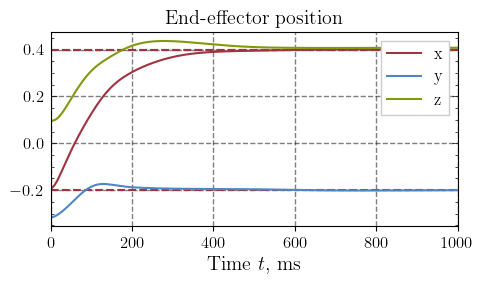

In [12]:
state_history = np.array(state_history)

plt.hlines(r_des, 0, len(state_history), linestyles="dashed")
plt.plot(state_history, label=['x','y','z'])
plt.grid()
plt.title('End-effector position')
plt.xlabel('Time $t$, ms')
plt.legend()
plt.show()

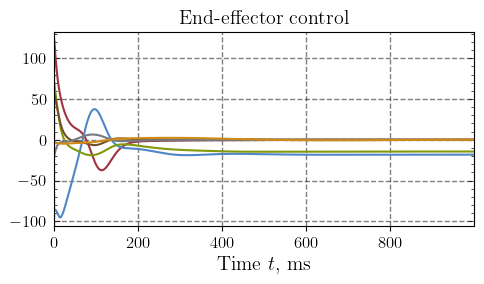

In [13]:
control_history = np.array(control_history)

plt.plot(control_history)
plt.grid()
plt.title('End-effector control')
plt.xlabel('Time $t$, ms')
plt.show()